## Predictive Model for Taxi Service

**Project Objectives:**

The project aims to develop a model that predicts the number of taxi orders for the next hour. To achieve this, the following steps will be taken:

1. Data Pre-processing
2. Exploratory Analysis
3. Data Preparation for Machine Learning
4. Model Selection and Training Algorithm
5. Training, Setting, Testing, and Checking Model Quality
6. Forecast and Conclusion

In alignment with the customer’s business objectives, the project involves creating a model for predicting taxi service load, specifically addressing peak hours (a linear regression problem for time series forecasting).

**Data Source:**

The dataset provided by the customer contains historical data on taxi orders at airports.

**Tools and libraries:**
- Python
- Pandas
- Matplotlib
- Numpy
- Sklearn
- Seaborn
- LightGBM

#  Прогнозная модель для предсказания заказов такси

**Аннотация проекта**

На данных сервиса такси проводится исследовательский анализ с последующей разработкой решения на основе моделирования, которое позволит компании оптимизировать сервис с учётом динамики заказов в час пик.

**Цель исследования** — разработать модель для прогноза количества заказов такси на следующий час. Для этого будут выполнены следующие шаги:

- Предварительная обработка данных.
- Исследовательский анализ.
- Подготовка данных для машинного обучения.
- Выбор модели и алгоритма её обучения.
- Обучение, настройка, тестирование и оценка качества моделей.
- Прогноз и выводы.

Учитывая бизнес-задачи заказчика, предстоит разработать прогнозную модель для предсказания загруженности сервиса такси с учётом часов пиковой нагрузки (задача линейной регрессии для прогнозирования временных рядов).

**Согласно условиям** показатель метрики *RMSE* на тестовой выборке не должен превышать значение 48.

**Описание данных**

Датасет, представленный заказчиком, содержит исторические данные о заказах такси в аэропортах.

**Инструменты и библиотеки:**
- Python
- Pandas
- Matplotlib
- Numpy
- Sklearn
- Seaborn
- LightGBM

In [1]:
! pip install phik -q


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
! pip install --upgrade scikit-learn -q


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# импорт библиотек, модулей и функций
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
import seaborn as sns
import lightgbm as lgb
import re, time
import warnings

# модуль для анализа временных рядов
from statsmodels.tsa.seasonal import seasonal_decompose
# модуль для оценки стационарности временных рядов
from statsmodels.tsa.stattools import adfuller
# функция для оценки автокорреляции
from statsmodels.graphics import tsaplots

# инструменты для пайплайн
from sklearn.pipeline import Pipeline
# функция для разделения датасета на выборки
from sklearn.model_selection import train_test_split

# классы для моделей машинного обучения
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

# инструменты для автоподбора гиперпараметров
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from scipy.stats import randint
# импорт функций для расчёта метрик
from sklearn.metrics import mean_squared_error
# модуль для создания контролируемого и воспроизводимого источника случайных чисел
from numpy.random import RandomState

In [4]:
# установим настройки для отображения всех столбцов датафрейма
pd.set_option('display.max_columns', None)

## Загрузка данных

- Загрузим файл и проверим, что данные в таблице соответствуют описанию.
- Выполним ресемплирование данных по одному часу.

In [5]:
# считываем данные из csv-файла и сохраняем в датафрейм
df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])
# выведем первые пять строк
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
# преобразуем индекс в объекты datetime
df.index = pd.to_datetime(df.index)
# сортировка, чтобы гарантировать, что ресемплинг будет выполнен на отсортированном индексе
df.sort_index(inplace=True)
# проверим в хронологическом ли порядке расположены дата и время
df.index.is_monotonic

True

In [7]:
# выполним ресемплинг с интервалом 1 час
df = df.resample('1H').sum()

In [8]:
# выведем первые пять строк
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [9]:
# оценим количество пропусков
df.isna().sum()

num_orders    0
dtype: int64

In [10]:
# выведем основную информацию о таблице
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


**Вывод:**
- Данные загружены и корректно отображаются в таблице.
- Таблица содержит два столбца, из них один входной признак формата даты и целевой признак числового типа.
- Столбец `num_orders` — целевой признак, содержит количественные значения числа заказов такси.
- Данные охватывают период с 2018-03-01 00:00:00 по 2018-08-31 23:00:00 и представлены с десятиминутным интервалом.
- Дата и время расположены в хронологическом порядке.
- Выполнена сортировка, чтобы гарантировать ресемплирование на отсортированном индексе. После ресемплинга данные представлены с часовым интервалом.
- Пропусков не обнаружено.

## Анализ и подготовка данных

1. Построим графики и оценим характеристики данных временных рядов.
2. Для адекватного обучения модели, которая по историческим данным предскажет будущие значения временного ряда, создадим новые признаки на основе данных временного ряда.

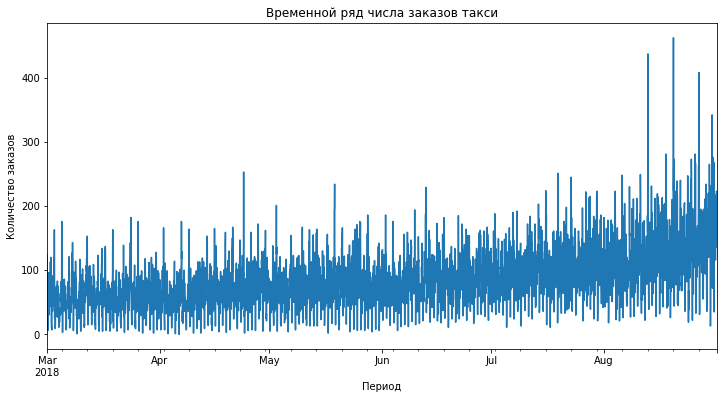

In [11]:
# визуализируем временной ряд
df['num_orders'].plot(figsize=(12, 6))
plt.title('Временной ряд числа заказов такси')
plt.xlabel('Период')
plt.ylabel('Количество заказов')
plt.show()

**Вывод:**
- На графике временной ряд стохастического процесса. На первый взгляд, имеет вид стационарного временного ряда.
- Однако, для более ясной оценки типа временного ряда, построим дополнительные графики по выделенным промежуткам.

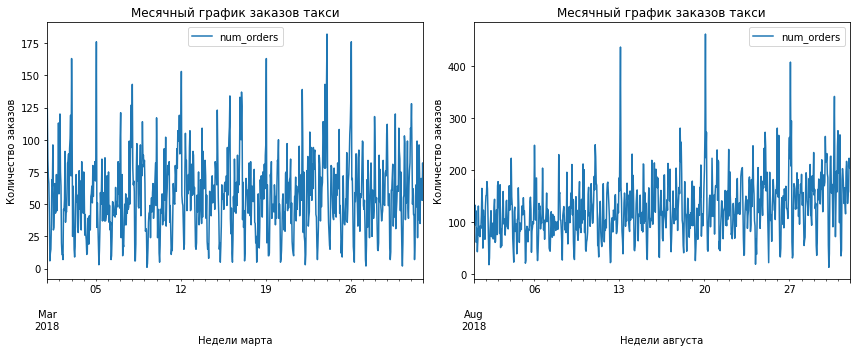

In [12]:
# рассмотрим графики заказов для первого и последнего месяцев периода
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

df.loc['2018-03'].plot(ax=axs[0], title='Месячный график заказов такси')
axs[0].set_xlabel('Недели марта')
axs[0].set_ylabel('Количество заказов')

df.loc['2018-08'].plot(ax=axs[1], title='Месячный график заказов такси')
axs[1].set_xlabel('Недели августа')
axs[1].set_ylabel('Количество заказов')

plt.tight_layout()
plt.show()

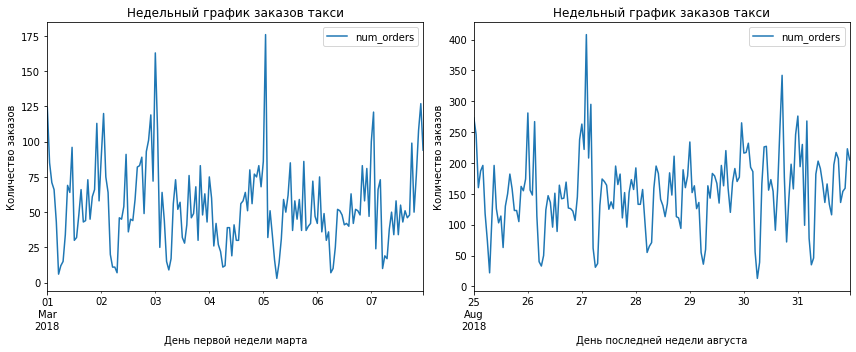

In [13]:
# рассмотрим недельный график заказов в первую и последнюю недели периода
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

df.loc['2018-03-01':'2018-03-07'].plot(ax=axs[0], title='Недельный график заказов такси')
axs[0].set_xlabel('День первой недели марта')
axs[0].set_ylabel('Количество заказов')

df.loc['2018-08-25':'2018-08-31'].plot(ax=axs[1], title='Недельный график заказов такси')
axs[1].set_xlabel('День последней недели августа')
axs[1].set_ylabel('Количество заказов')

plt.tight_layout()
plt.show()

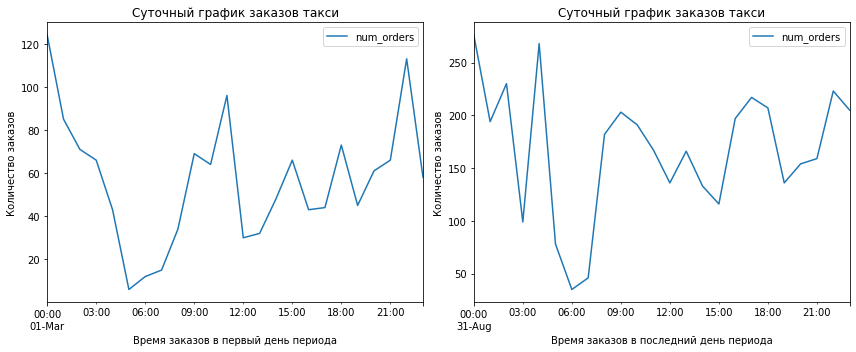

In [14]:
# рассмотрим суточный график заказов в первый и последний дни периода
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

df.head(24).plot(ax=axs[0], title='Суточный график заказов такси')
axs[0].set_xlabel('Время заказов в первый день периода')
axs[0].set_ylabel('Количество заказов')

df.tail(24).plot(ax=axs[1], title='Суточный график заказов такси')
axs[1].set_xlabel('Время заказов в последний день периода')
axs[1].set_ylabel('Количество заказов')

plt.tight_layout()
plt.show()

**Вывод:**
- Оценка отдельных срезов в промежутке *месяц — неделя — день* слабо проясняет характер данных.
- Можно проследить суточные пики заказов такси в районе полуночи и спады ранним утром.
- Далее построим сводный график заказов такси по дням недели.

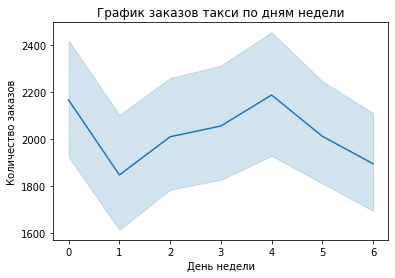

In [15]:
# построим сводный график заказов такси по дням недели
df_wd = df.resample('1D').sum()
df_wd = df_wd.assign(wd=df_wd.index.weekday)

sns.lineplot(data=df_wd, x='wd', y='num_orders')
plt.xlabel('День недели')
plt.ylabel('Количество заказов')
plt.title('График заказов такси по дням недели')
plt.show()

**Вывод:**
- График показывает устойчивую популярность заказов такси в понедельник и в пятницу.
- Далее проследим сезонность и тенденции. Сделаем декомпозицию с ресемплированием по часу. Рассмотрим период в несколько дней и оценим суточную сезонность, то есть как количество заказов зависит от времени суток.

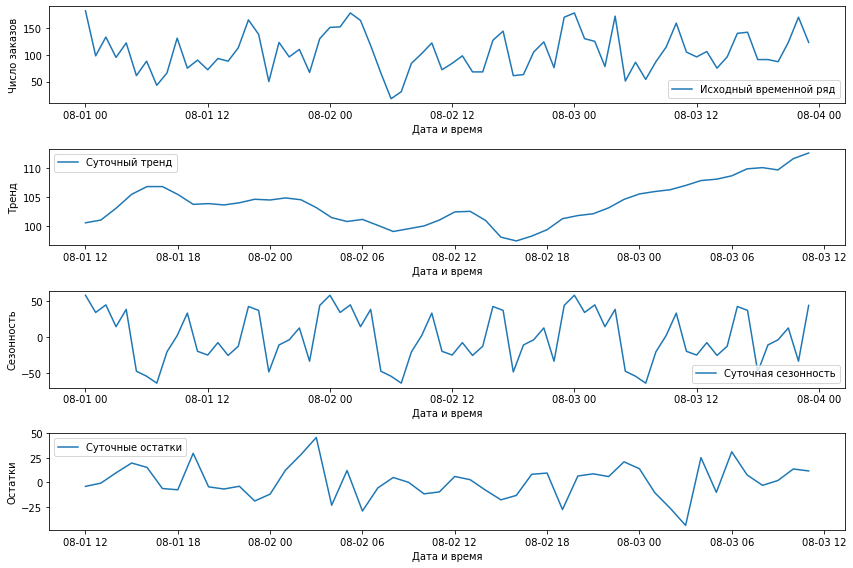

In [16]:
# извлечение определенного периода
df_hourly = df['2018-08-01':'2018-08-03']

# сезонная декомпозиция
result = seasonal_decompose(df_hourly['num_orders'], model='additive', period=24)

# графики декомпозиции
plt.figure(figsize=(12, 8))

# исходный временной ряд
plt.subplot(4, 1, 1)
plt.plot(df_hourly['num_orders'], label='Исходный временной ряд')
plt.legend()
plt.xlabel('Дата и время')
plt.ylabel('Число заказов')

# график тренда
plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Суточный тренд')
plt.legend()
plt.xlabel('Дата и время')
plt.ylabel('Тренд')

# график сезонности
plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Суточная сезонность')
plt.legend()
plt.xlabel('Дата и время')
plt.ylabel('Сезонность')

# график остатков
plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Суточные остатки')
plt.legend()
plt.xlabel('Дата и время')
plt.ylabel('Остатки')

plt.tight_layout()
plt.show()

**Исследуем остатки** по всему периоду (5 месяцев), чтобы проследить будет ли изменение в какой-то из периодов. Тогда увеличение количества и разброса остатков в конце графика — к августу, будет говорить о том, что модели будет сложнее, выучив закономерности предыдущего периода, корректно предсказывать количество заказов на август.

В таком случае можно предположить, что ожидаем снижение качества модели на тестовой выборке и это не будет связанно с качеством модели.

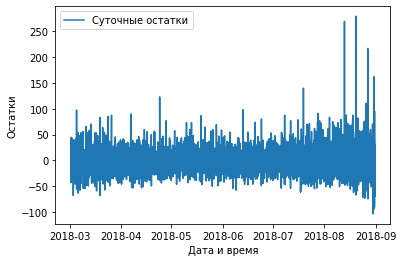

In [17]:
# декомпозиция остатков по всему периоду
res = seasonal_decompose(df['num_orders'])

plt.plot(res.resid, label='Суточные остатки')
plt.legend()
plt.xlabel('Дата и время')
plt.ylabel('Остатки')

plt.show()

**Вывод:**
- Оценивая общий тренд, можно отметить, что число заказов такси увеличивается в зависимости от времени суток.
- Сезонность связана с периодами в пределах суток, в частности, со временем полуночи.
- График остатков отражает основные закономерности временного ряда. Необычно большие остатки в определенных точках могут указывать на выбросы или аномалии в данных, это может привести к неточным прогнозам в аналогичных случаях в будущем.
- Прогнозировать данные помогают стационарные ряды. Стационарные временные ряды — это ряды, у которых среднее и стандартное отклонение не меняются.
- Для проверки стационарности используем тест Дики-Фуллера. 

In [18]:
# тест Дики-Фуллера
adf_result = adfuller(df['num_orders'])
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

ADF Statistic: -3.068924289027954
p-value: 0.028940051402613028


**Вывод:**
- Тест показывает значение p меньше уровня значимости, следовательно данные можно считать стационарными.
- Далее для корректного обучения модели, создадим новые признаки на основе данных временного ряда.

В нашем распоряжении данные за шесть месяцев, значит годовую сезонность проследить невозможно. При этом можно предсказать сезонность в пределах месяца, **создав признаки** на уровень ниже месяца, то есть недельные отстающие значения/лаги.

In [19]:
# функция добавит в датафрейм три календарных признака: день, день недели и час
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    # создает отстающие признаки для выявления временных зависимостей и закономерностей в данных 
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    # вычисляет скользящее среднее значение для выявления общего тренда временного ряда
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Один из самых важных признаков в задаче временных рядов — это так называемые «лаги», то есть, значения предыдущих периодов наблюдения. Мы помним, что модель не считает по столбцам таблицы, она считает и подбирает веса к строкам датасета. Соответственно, если мы хотим, чтобы модель предсказывала следующее значение, опираясь на предыдущие, нужно, чтобы она эти предыдущие значения увидела (по горизонтали датасета).
Поэтому важно создать новые колонки с отстающими значениями. Особенно полезны будут те лаги, которые имеют высокую корреляцию с таргетом. 

Логично, что высокая корреляция будет при выраженной сезонности. Если у нас посуточная сезонность, то каждый час одних суток будет немного похож по динамике заказов на тот же час предыдущих суток (например, к 17:00 количество заказов увеличивается, к 00:00 еще, а к 6:00 падает до минимума, и так каждый день). Значит, нам понадобится 24-й лаг, который будет отражать суточную сезонность. Если есть недельная сезонность, то по этой же причине нам будет очень важен 168-й лаг (24 часа * 7 дней = 168).

Значимость лагов можно посмотреть по **автокорреляции**.

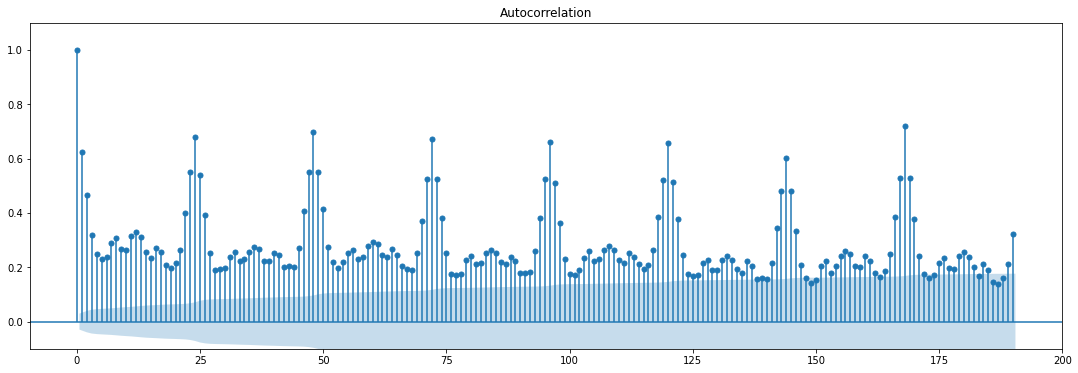

In [20]:
# оценка значимости лагов
ts = df['num_orders']

fig = tsaplots.plot_acf(ts,lags= 190)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 

**Вывод:**
- Функция показывает, как признак коррелирует с предыдущими. Область синей заливки обозначает порог статистической значимости, если значение внутри, корреляция уже не заслуживает доверия (статзначимость вычисляется по тесту Стьюдента).

In [21]:
# вызовем функцию 
make_features(df, 168, 168)
df.head()

,num_orders,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34,lag_35,lag_36,lag_37,lag_38,lag_39,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_49,lag_50,lag_51,lag_52,lag_53,lag_54,lag_55,lag_56,lag_57,lag_58,lag_59,lag_60,lag_61,lag_62,lag_63,lag_64,lag_65,lag_66,lag_67,lag_68,lag_69,lag_70,lag_71,lag_72,lag_73,lag_74,lag_75,lag_76,lag_77,lag_78,lag_79,lag_80,lag_81,lag_82,lag_83,lag_84,lag_85,lag_86,lag_87,lag_88,lag_89,lag_90,lag_91,lag_92,lag_93,lag_94,lag_95,lag_96,lag_97,lag_98,lag_99,lag_100,lag_101,lag_102,lag_103,lag_104,lag_105,lag_106,lag_107,lag_108,lag_109,lag_110,lag_111,lag_112,lag_113,lag_114,lag_115,lag_116,lag_117,lag_118,lag_119,lag_120,lag_121,lag_122,lag_123,lag_124,lag_125,lag_126,lag_127,lag_128,lag_129,lag_130,lag_131,lag_132,lag_133,lag_134,lag_135,lag_136,lag_137,lag_138,lag_139,lag_140,lag_141,lag_142,lag_143,lag_144,lag_145,lag_146,lag_147,lag_148,lag_149,lag_150,lag_151,lag_152,lag_153,lag_154,lag_155,lag_156,lag_157,lag_158,lag_159,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

**Вывод:**
- Итоговый датасет включает следующие типы признаков: календарные признаки, отстающие значения и скользящее среднее.
- Из-за специфики создания отстающих признаков в первых строках датасета появились пропущенные значения. Пропуски удалим.

In [22]:
# удаление пропусков
df = df.dropna()

## Обучение моделей

1. Протестируем три модели: *LinearRegression()*, *RandomForestRegressor()*, *LGBMRegressor()*.
2. Для каждой подберём гиперпараметры, используя рандомизированный поиск и *TimeSeriesSplit* для корректного разделения временных рядов в перекрестной проверке.
3. Оценим точность прогнозов моделей при помощи метрики *RMSE*, которая измеряет среднюю величину ошибок между прогнозируемыми и фактическими значениями.

In [23]:
# объявляем константы
RANDOM_STATE = 42

# разделяем датасет на выборки
X = df.drop('num_orders', axis=1)
y = df['num_orders']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

In [ ]:
%%time
# pipeline
pipe = Pipeline([
    ('models', LinearRegression())
])

# установим параметры для моделей
param_grid = [
    # базовая модель Linear Regression
    {
        'models': [LinearRegression()],
        'models__fit_intercept': [True, False]
    },
    # параметры для Random Forest Regressor
    {
        'models': [RandomForestRegressor()],
        'models__n_estimators': randint(100, 500),
        'models__max_depth': [None, 10, 20, 30, 40, 50],
        'models__min_samples_split': [2, 5, 10],
        'models__min_samples_leaf': [1, 2, 4]
    },
    # параметры для LGBM Regressor
    {
        'models': [LGBMRegressor(boosting_type='gbdt', random_state=RANDOM_STATE)],
        'models__learning_rate': [0.01, 0.05, 0.1],
        'models__num_leaves': [30, 50, 70],
        'models__n_estimators': [100, 500, 1000]
    }
]

# TimeSeriesSplit для корректного разделения временных рядов в перекрестной проверке
tscv = TimeSeriesSplit(n_splits=5)

# рандомизированный поиск
randomized_search = RandomizedSearchCV(
    pipe,
    param_distributions=param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# обучаем модель
randomized_search.fit(X_train, y_train)

# выведем результаты оценки 10 лучших моделей
results = pd.DataFrame(randomized_search.cv_results_)
with pd.option_context('max_colwidth', 3000):
    display(results[['rank_test_score', 'param_models', 'mean_test_score', 'params']]
            .sort_values('rank_test_score').head(10))

In [ ]:
# график параллельных координат
plot_cols = ['param_models__n_estimators', 'param_models__max_depth', 'param_models__min_samples_split']
plt.figure(figsize=(12, 8))
parallel_coordinates(results[plot_cols + ['mean_test_score']], 'mean_test_score')
plt.title('График параллельных координат гиперпараметров')
plt.show()

**Вывод:**
- `param_models__n_estimators` — количество деревьев в модели ансамбля для `RandomForestRegressor` и `LGBMRegressor` существенно влияет на производительность моделей.
- Более высокое значение `max_depth` может отразить более сложные взаимосвязи в данных, но также может привести к переобучению. Одним из показателей переобучения будет являться более низкая оценка модели на тестовой выборке.

## Тестирование модели

1. Проанализируем производительность моделей.
2. Оценим качество лучшей модели на тестовой выборке.

In [ ]:
# вывод соответствующей информации
print("Сравнение моделей:")
print("---------------------------------------------------------------------------------------------------")
print("{:<25} | {:<20} | {:<23} | {:<12}".format("Модель", "Время обучения (сек)", "Время прогноза (сек)", "RMSE оценка"))
print("---------------------------------------------------------------------------------------------------")

# вывод информации для каждой модели
for i in range(results.shape[0]):
    model_name = results.loc[i, "param_models"].__class__.__name__
    train_time = results.loc[i, "mean_fit_time"]
    pred_time = results.loc[i, "mean_score_time"]
    rmse_score = -results.loc[i, "mean_test_score"]

    print("{:<25} | {:<20.3f} s | {:<23.3f} s | {:<12.0f}".format(model_name, train_time, pred_time, rmse_score))

print("---------------------------------------------------------------------------------------------------")

# параметры лучшей модели с учетом прогнозных способностей
best_model_idx = results["mean_test_score"].idxmax()
best_model_params = results.loc[best_model_idx, "params"]
best_model_metric = -results.loc[best_model_idx, "mean_test_score"]

print("\nЛучшая модель:")
print("---------------------------------------------------------------------------------------------------")
print("Параметры:", best_model_params)
print("RMSE оценка: {:.2f}".format(best_model_metric))

**Вывод:**

Анализируя производительность различных конфигураций гиперпараметров для моделей регрессии, отметим следующее:
- Наиболее эффективной моделью согласно метрике оказалась базовая модель `LinearRegression`.
- `RandomForestRegressor` и `LGBMRegressor` также показывают высокие оценки, однако, время обучения при текущих параметрах для указанных моделей значительно более затратно по сравнению с моделью линейной регрессии.
- Таким образом, в данном контексте базовая модель `LinearRegression` оказалась более эффективной с точки зрения прогнозных способностей и скорости обучения.

In [ ]:
# оценка на тестовой выборке
best_model = randomized_search.best_estimator_
y_pred_test = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f'RMSE на тестовой выборке: {test_rmse:.0f}')

In [ ]:
# проверка модели на адекватность
pred_previous = y_test.shift()
pred_previous.iloc[0] = y_train.iloc[-1]

In [ ]:
# выводим бейзлайн при константном предсказании предыдущим значением
np.sqrt(mean_squared_error(y_test, pred_previous))

In [ ]:
# график результатов проверки
plt.figure(figsize=(18, 8))
plt.xlabel('Временной период')
plt.ylabel('Количество заказов такси')
plt.title('Сравнение исходных и предсказанных значений')

plt.plot(y_test, label='Исходные значения')
plt.plot(pred_previous, label='Предсказанные значения')

plt.legend()
plt.show()

**Вывод:**
- Заметна существенная разница в производительности модели между обучающим и тестовым наборами. Это может указывать на потенциальные проблемы с переобучением. Оценки RMSE составили 23 и 34 соответственно.
- Похоже модель слишком хорошо уловила закономерности обучающего набора, которые плохо обобщаются на новом, не знакомом наборе.
- При этом прогнозные способности модели удовлетворяют условиям заказчика — показатель метрики RMSE на тестовой выборке составляет 34, то есть не превышает значение 48.

## Итоговый вывод

На данных сервиса такси был проведён исследовательский анализ с последующей разработкой решения на основе моделирования, которое позволит компании оптимизировать сервис с учётом динамики заказов в час пик.

Учитывая бизнес-задачи заказчика предстояло разработать модель для прогноза количества заказов такси на следующий час с учётом пиковой нагрузки (задача линейной регрессии для прогнозирования временных рядов).

Работа включала предварительный этап, исследовательский анализ данных, обучение разных моделей с подбором гиперпараметров, анализ моделей и проверку на тестовой выборке.

На **предварительном этапе** мы изучили основные сведения о датасете, определили количество и тип данных в таблице, проверили на наличие пропусков и убедились, что все данные отображаются корректно.

На этапе **исследовательского анализа** были построены графики для оценки характера данных временных рядов, для проверки стационарности использовался тест Дики-Фуллера. Кроме того, для адекватного обучения модели, которая по историческим данным предскажет будущие значения временного ряда, были созданы новые признаки на основе данных временного ряда.

Этап **разработки модели** включал подготовку данных для обучения, настройку гиперпараметров, обучение модели оценку качества с использованием метрики RMSE и получение прогнозных значений.

На этапе **анализа моделей** проводилось сопоставление результатов с учётом оценки качества прогноза и гиперпараметров.

В контексте поставленной задачи мы рассмотрели возможности следующих регрессоров:
- `LinearRegression()` — служит базовой или эталонной моделью во время настройки гиперпараметров, чтобы на её основе найти модели, которые работают значительно лучше, чем базовый уровень.
- `RandomForestRegressor()` — метод ансамблевого обучения, благодаря усреднению по нескольким деревьям, случайный лес может быть более надежным и менее склонным к переобучению.
- `LGBMRegressor()` — использует древовидные алгоритмы обучения с градиентным бустингом, деревья решений строятся таким образом, чтобы оптимизировать уменьшение функции потерь на каждом этапе.

**Основные результаты:**

1. В ходе исследовательского анализа удалось проследить некоторые закономерности в данных временного ряда. В частности:
- Отмечаются суточные пики заказов такси в районе полуночи и спады ранним утром.
- Сводный график заказов такси по дням недели показывает устойчивую популярность сервиса в понедельник и в пятницу.
- Тренд связан с временем года: летом число заказов такси, по сравнению с весной, выше.
2. Результат **теста Дики-Фуллера** показал, что данные можно считать стационарными (p-value: 0.028).
3. Для адекватного обучения модели, которая по историческим данным предскажет будущие значения временного ряда, были созданы **новые признаки** на основе данных временного ряда: *календарные признаки*, *отстающие значения* и *скользящее среднее*.
4. Из трёх моделей наиболее эффективной с точки зрения **прогнозных способностей** оказалась базовая модель `LinearRegression`.
- Оценка **RMSE** лучшей модели на **тренировочной** выборке составила *23*, на **тестовой** *34*. Такая существенная разница в производительности модели между обучающим и тестовым наборами может указывать на потенциальные проблемы с переобучением. По-видимому, модель слишком хорошо уловила закономерности обучающего набора, которые плохо обобщаются на новом, не знакомом наборе.
- `RandomForestRegressor` и `LGBMRegressor` также показывают высокие оценки, однако, время обучения при текущих параметрах для указанных моделей значительно более затратно по сравнению с моделью линейной регрессии.
5. Таким образом, в данном контексте базовая модель `LinearRegression` оказалась более эффективной с точки зрения прогнозных способностей и скорости обучения. Однако, потенциал всех протестированных алгоритмов не ограничевается рамками данного исследования.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48